## Sentiment Analysis of Emotions Dataset (Multiclass)

Saved as 'distilbert-base-uncased-Emotions_Detection' on my HuggingFace profile

Source for the Dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=test.txt

### Exploratory Data Analysis & Preprocessing in Pandas

#### Import Necessary Libraries

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM']='false'

from pathlib import Path

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

import datasets
from datasets import Dataset, DatasetDict, load_metric

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, set_seed, DataCollatorWithPadding

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Many Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.3
NumPy:             1.22.4
Torch:             1.12.1


#### Ingest & Preprocess Training Dataset

In [3]:
train_df = pd.read_csv('~/Desktop/Spark Datasets/Emotions Dataset for NLP/train.txt', delimiter=';', header=None, engine="c")

train_df.rename(columns={1 : 'labels', 0 : 'text'}, inplace=True)
train_df = train_df.apply(lambda x: x.str.strip())

train_df.head()

,text,labels
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


#### Visualize: Histogram of Text Lengths

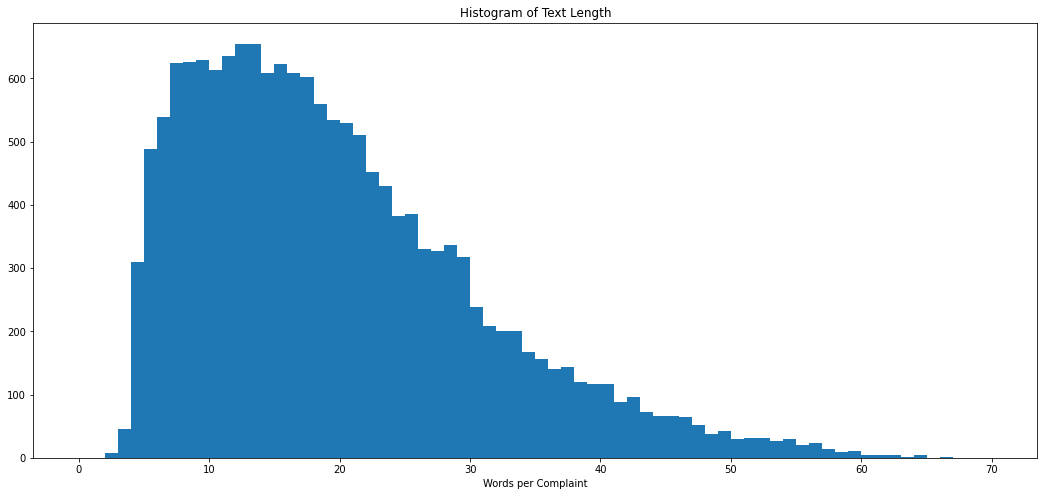

In [4]:
train_df['Text Length'] = train_df['text'].str.split().str.len()
train_df.hist('Text Length', grid=False, range=(0,70), bins=70, figsize=(18,8))

plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Complaint')
plt.show()

#### Visualize Description Lengths (By Output Class)

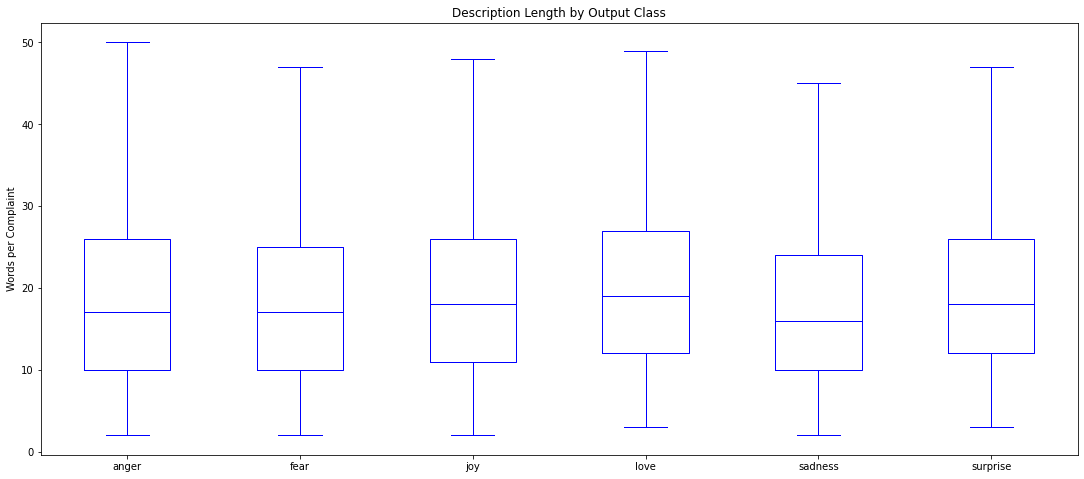

In [5]:
train_df.boxplot("Text Length", by="labels", grid=False, showfliers=False, color="Blue", figsize=(18, 8))

plt.suptitle('')
plt.title('Description Length by Output Class')
plt.xlabel('')
plt.ylabel('Words per Complaint')
plt.show()

#### Distribution of Results

In [6]:
train_df['labels'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: labels, dtype: int64

#### Unique Classes

In [7]:
labels_names = train_df['labels'].unique()
num_of_labels = len(labels_names)
print(labels_names, '\n', num_of_labels)

cols_convert2_int = {'sadness' : 0, 'anger' : 1, 'love' : 2, 'surprise' : 3, 'fear' : 4, 'joy' : 5}

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy'] 
 6


#### Ingest & Preprocess Testing Dataset

In [8]:
test_df = pd.read_csv('~/Desktop/Spark Datasets/Emotions Dataset for NLP/test.txt', delimiter=';', header=None, engine="c")

test_df.rename(columns={1 : 'labels', 0 : 'text'}, inplace=True)
test_df = test_df.apply(lambda x: x.str.strip())

test_df.head()

,text,labels
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


#### Ingest & Preprocess Validation Dataset

In [9]:
eval_df = pd.read_csv('~/Desktop/Spark Datasets/Emotions Dataset for NLP/val.txt', delimiter=';', header=None, engine="c")

eval_df.rename(columns={1 : 'labels', 0 : 'text'}, inplace=True)
eval_df = eval_df.apply(lambda x: x.str.strip())

eval_df.head()

,text,labels
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


#### Final Data Preprocessing

In [10]:
train_df = train_df[train_df['Text Length'] < 70]

train_df = train_df.drop(columns=['Text Length'])

train_df['labels'].replace(cols_convert2_int, inplace=True)
test_df['labels'].replace(cols_convert2_int, inplace=True)
eval_df['labels'].replace(cols_convert2_int, inplace=True)

train_df.info()
test_df.info()
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   labels  16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   labels  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   labels  2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


### Regular Project

#### Basic Constants/Values

In [11]:
model_ckpt = 'distilbert-base-uncased'
device="cpu"
max_input_length = 91
set_seed(42)
batch_size = 64
num_of_epochs = 4

#### Convert Pandas DataFrame to Dataset; Then Split into Train/Test/Valid Datasets

In [12]:
# Convert pandas dataframe to a dataset
ds_train = Dataset.from_pandas(train_df)
ds_test = Dataset.from_pandas(test_df)
ds_eval = Dataset.from_pandas(eval_df)

# Combine the train/test/valid into one datasetdict
ds = DatasetDict({
    'train' : ds_train,
    'test' : ds_test,
    'valid' : ds_eval
})

print('training data shape:', ds['train'].shape)
print('testing data shape:', ds['test'].shape)
print('validation data shape:', ds['valid'].shape)
print(ds['train'].features)

training data shape: (16000, 3)
testing data shape: (2000, 2)
validation data shape: (2000, 2)
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


#### Tokenize Entire Dataset

In [13]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=91, return_tensors="np")

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['valid'].shape)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

training data shape: (16000, 5)
testing data shape: (2000, 4)
validation data shape: (2000, 4)


#### Print Example to Ensure Edits Worked as Expected

In [14]:
print(encoded_data['train'].features)
print(encoded_data['train'])

print(encoded_data['valid'].features)
print(encoded_data['valid'])

print(encoded_data['test'].features)
print(encoded_data['test'])

print((encoded_data['test']['labels'][9]))

{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 16000
})
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 2000
})
{'text': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), len

#### Instantiate Model

In [15]:
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_of_labels).to(device))
model.config.num_labels

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

6

#### Ensure git lfs is Installed; Remember to Enter Access Token

In [16]:
!git lfs install

# HuggingFace Access Token ...

Git LFS initialized.


#### Define Function to Compute Metrics

In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1_score": f1}

#### Instantiate TrainingArguments

In [18]:
learning_rate=2e-5

model_name = f"{model_ckpt}-Emotions_Detection"

training_args = TrainingArguments(output_dir=model_name,
                        num_train_epochs=num_of_epochs,
                        learning_rate=learning_rate,
                        per_device_train_batch_size=batch_size, 
                        per_device_eval_batch_size=batch_size, 
                        weight_decay=0.01,
                        log_level="error",
                        logging_strategy='epoch', 
                        hub_strategy="checkpoint",
                        evaluation_strategy="epoch",
                        save_strategy="epoch",
                        save_total_limit=5,
                        load_best_model_at_end=True,
                        metric_for_best_model="f1_score",
                        greater_is_better=True,
                        logging_first_step=True,
                        disable_tqdm=False,
                        push_to_hub=True)

#### Instantiate Data Collator

In [19]:
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Correctl Compute Loss for Imbalanced Classes

In [20]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0,]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [21]:
trainer = CustomTrainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_data['train'], 
                  eval_dataset=encoded_data['valid'], 
                  data_collator=data_collator,
                  tokenizer=tokenizer)

Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-Emotions_Detection into local empty directory.


#### Train Model

In [22]:
trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ch4/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 1.7336, 'learning_rate': 1.9980000000000002e-05, 'epoch': 0.0}
{'loss': 0.7287, 'learning_rate': 1.5000000000000002e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.25972381234169006, 'eval_accuracy': 0.8955, 'eval_f1_score': 0.8948022836666599, 'eval_runtime': 285.7294, 'eval_samples_per_second': 7.0, 'eval_steps_per_second': 0.112, 'epoch': 1.0}
{'loss': 0.2054, 'learning_rate': 1e-05, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.16384392976760864, 'eval_accuracy': 0.9325, 'eval_f1_score': 0.9326052321267978, 'eval_runtime': 287.0329, 'eval_samples_per_second': 6.968, 'eval_steps_per_second': 0.111, 'epoch': 2.0}
{'loss': 0.1338, 'learning_rate': 5e-06, 'epoch': 3.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.14151246845722198, 'eval_accuracy': 0.935, 'eval_f1_score': 0.9349669876769724, 'eval_runtime': 285.0049, 'eval_samples_per_second': 7.017, 'eval_steps_per_second': 0.112, 'epoch': 3.0}
{'loss': 0.1067, 'learning_rate': 0.0, 'epoch': 4.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.14396128058433533, 'eval_accuracy': 0.9345, 'eval_f1_score': 0.9347098524383352, 'eval_runtime': 285.0021, 'eval_samples_per_second': 7.017, 'eval_steps_per_second': 0.112, 'epoch': 4.0}
{'train_runtime': 36266.4063, 'train_samples_per_second': 1.765, 'train_steps_per_second': 0.028, 'train_loss': 0.2946525176763535, 'epoch': 4.0}


TrainOutput(global_step=1000, training_loss=0.2946525176763535, metrics={'train_runtime': 36266.4063, 'train_samples_per_second': 1.765, 'train_steps_per_second': 0.028, 'train_loss': 0.2946525176763535, 'epoch': 4.0})

### Assessing the Results of the Fine-Tuned Model

#### Calculate Predictions for Fine-Tuned Model

In [23]:
output_predictions = trainer.predict(encoded_data['valid'])

output_predictions.metrics

  0%|          | 0/32 [00:00<?, ?it/s]

{'test_loss': 0.14151246845722198,
 'test_accuracy': 0.935,
 'test_f1_score': 0.9349669876769724,
 'test_runtime': 288.5569,
 'test_samples_per_second': 6.931,
 'test_steps_per_second': 0.111}

#### Extract Last Hidden States

In [24]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}   
    with torch.no_grad():
        last_hidden_state = model(**inputs)[0]
    return {"hidden_state" : last_hidden_state[:,0].cpu().numpy()}

encoded_data.set_format("torch", columns=['input_ids', 'attention_mask', 'labels']) 

hidden_data = encoded_data.map(extract_hidden_states, batched=True)
print(hidden_data)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})


#### Create Feature Matrix

In [25]:
X_train = np.array(hidden_data['train']['hidden_state'])
X_valid = np.array(hidden_data['valid']['hidden_state'])
y_train = np.array(hidden_data['train']['labels'])
y_valid = np.array(hidden_data['valid']['labels'])
X_train.shape, X_valid.shape

((16000,), (2000,))

#### Define Function to Display Confusion Matrix

In [26]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(11, 11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Convert Logits to Predictions; Display Confusion Matrix for Fine-Tuned Model

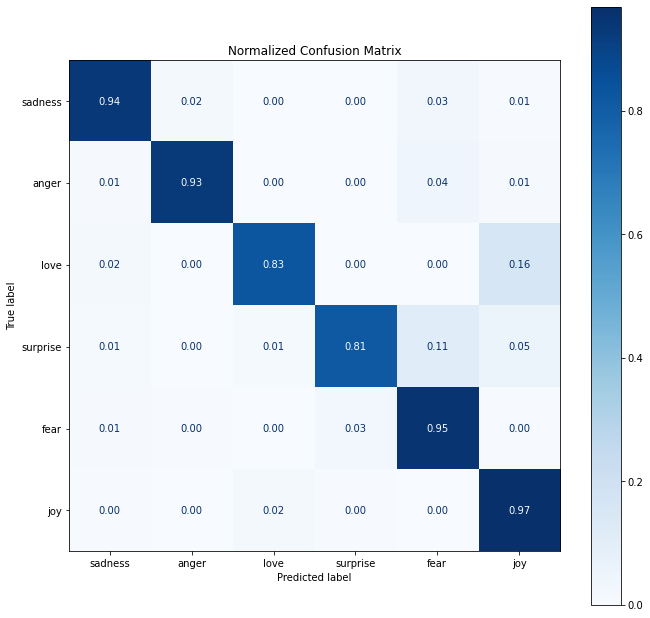

In [27]:
y_preds = np.argmax(output_predictions.predictions, axis=1)

names_of_labels = [((x+1)*1.0) for x in range(0, 6)]
names_of_labels = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'] 

plot_confusion_matrix(y_preds, y_valid, labels=names_of_labels)

### Final Steps

#### Push Fine-Tuned Model to HuggingFace Hub (My Profile)

In [28]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Upload file runs/Oct01_19-24-58_Brians-Mac-mini/events.out.tfevents.1664670305.Brians-Mac-mini.1184.0: 100%|##…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Emotions_Detection
   62d1266..8b1d057  main -> main

To https://huggingface.co/DunnBC22/distilbert-base-uncased-Emotions_Detection
   8b1d057..cae6215  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-uncased-Emotions_Detection/commit/8b1d05712067a8fc818a6b03b4d61f5bee415f8f'